#**Imports necessary libraries like OpenCV, NumPy, TensorFlow, and sklearn for image processing and modeling.**

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from google.colab import files
from tensorflow.keras.models import load_model

#**Defines image preprocessing functions (e.g., brain contour cropping) and loads augmented data from 'augmented data' folder with 240x240 size and normalization.**

In [3]:
def crop_brain_contour(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]  # Handle OpenCV version differences
        if len(cnts) == 0:
            return image
        c = max(cnts, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
        return new_image
    except:
        return image  # Return original if cropping fails

# Load and preprocess images from 'augmented data' folder
def load_and_preprocess_images(data_dir, img_size=(240, 240)):
    images = []
    labels = []
    for label in ['yes', 'no']:
        folder = os.path.join(data_dir, label)
        if not os.path.exists(folder):
            print(f"Warning: Folder {folder} not found")
            continue
        class_label = 1 if label == 'yes' else 0
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = crop_brain_contour(img)
                img = cv2.resize(img, img_size)
                img = img / 255.0  # Normalize to [0, 1]
                images.append(img)
                labels.append(class_label)
    return np.array(images), np.array(labels)

# Load augmented data
data_dir = 'augmented data'  # Path as specified in GitHub
X, y = load_and_preprocess_images(data_dir)
print(f"Loaded {len(X)} images (Expected ~2065)")

Loaded 2065 images (Expected ~2065)


#**Generates additional augmented data using ImageDataGenerator if the dataset size is below the expected ~2065 images, balancing classes.**

In [4]:
aug_dir = 'augmented_data_extra'
os.makedirs(os.path.join(aug_dir, 'yes'), exist_ok=True)
os.makedirs(os.path.join(aug_dir, 'no'), exist_ok=True)

# ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Function to augment data if needed
def augment_data(X, y, target_count=1085):
    augmented_images = []
    augmented_labels = []
    for class_label in [0, 1]:
        class_images = X[y == class_label]
        if len(class_images) >= target_count:
            augmented_images.extend(class_images)
            augmented_labels.extend([class_label] * len(class_images))
            continue
        num_needed = target_count - len(class_images)
        num_generated = 0
        for img in class_images:
            img = np.expand_dims(img, 0)
            for _ in range(5):  # Generate up to 5 per image
                for batch in datagen.flow(img, batch_size=1, save_to_dir=os.path.join(aug_dir, 'yes' if class_label == 1 else 'no'), save_prefix='aug', save_format='jpg'):
                    augmented_images.append(batch[0])
                    augmented_labels.append(class_label)
                    num_generated += 1
                    if num_generated >= num_needed:
                        break
                if num_generated >= num_needed:
                    break
        augmented_images.extend(class_images)
        augmented_labels.extend([class_label] * len(class_images))
    return np.array(augmented_images), np.array(augmented_labels)

# Apply augmentation if loaded data is less than ~2065
if len(X) < 2000:
    print("Applying additional augmentation to reach ~2065 images")
    X, y = augment_data(X, y, target_count=1085)  # ~1085 yes, ~980 no
print(f"After augmentation (if applied): {len(X)} images")

After augmentation (if applied): 2065 images


#**Splits data into training (70%), validation (15%), and test (15%) sets using train_test_split while maintaining class balance.**

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)} (~70%), Val: {len(X_val)} (~15%), Test: {len(X_test)} (~15%)")

Train: 1445 (~70%), Val: 310 (~15%), Test: 310 (~15%)


#**Builds a simple CNN model with ZeroPadding, Conv2D, BatchNormalization, Activation, MaxPooling, and Dense layers for binary classification, compiled with Adam and binary_crossentropy.**

In [6]:
model = Sequential([
    ZeroPadding2D(padding=(2, 2), input_shape=(240, 240, 3)),
    Conv2D(32, (7, 7), strides=1),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(4, 4), strides=4),
    MaxPooling2D(pool_size=(4, 4), strides=4),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 238, 238, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

#**Displays the model architecture summary using model.summary() to review layers and parameters.**

Epoch 1/24
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5936 - loss: 1.0468
Epoch 1: val_accuracy improved from -inf to 0.57742, saving model to best_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.5943 - loss: 1.0418 - val_accuracy: 0.5774 - val_loss: 0.6623
Epoch 2/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7409 - loss: 0.5118
Epoch 2: val_accuracy improved from 0.57742 to 0.73226, saving model to best_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7422 - loss: 0.5100 - val_accuracy: 0.7323 - val_loss: 0.6153
Epoch 3/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8381 - loss: 0.4066
Epoch 3: val_accuracy did not improve from 0.73226
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8381 - loss: 0.4060 - val_accuracy: 0.4774 - val_loss: 0.7825
Epoch 4/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8214 - loss: 0.3866
Epoch 4: val_accuracy did not improve from 0.73226
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8218 - loss: 0.3858 - val_accuracy: 0.6290 - val_loss: 0.6070
Epoch 5/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8786 - loss: 0.3098
Epoch 5: val_accuracy did not improve from 0.73226
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8787 - loss: 0.3094 - val_accuracy: 0.5258 - val_loss: 0.7486
Epoch 6/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8888 - loss: 0.2675
Epoch 6: val_accuracy did not improve from 

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9192 - loss: 0.2148 - val_accuracy: 0.8129 - val_loss: 0.3928
Epoch 10/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9152 - loss: 0.2028
Epoch 10: val_accuracy improved from 0.81290 to 0.83226, saving model to best_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9152 - loss: 0.2029 - val_accuracy: 0.8323 - val_loss: 0.3913
Epoch 11/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9032 - loss: 0.2323
Epoch 11: val_accuracy did not improve from 0.83226
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9037 - loss: 0.2316 - val_accuracy: 0.8161 - val_loss: 0.4131
Epoch 12/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9275 - loss: 0.1717
Epoch 12: val_accuracy did not improve from 0.83226
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9282 - loss: 0.1713 - val_accuracy: 0.8032 - val_loss: 0.4915
Epoch 13/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9500 - loss: 0.1420
Epoch 13: val_accuracy improved from 0.83226 to 0.86129, saving model to best_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9501 - loss: 0.1421 - val_accuracy: 0.8613 - val_loss: 0.3284
Epoch 14/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9209 - loss: 0.1893
Epoch 14: val_accuracy did not improve from 0.86129
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9211 - loss: 0.1888 - val_accuracy: 0.8065 - val_loss: 0.4950
Epoch 15/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9535 - loss: 0.1444
Epoch 15: val_accuracy did not improve from 0.86129
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9534 - loss: 0.1443 - val_accuracy: 0.8355 - val_loss: 0.4119
Epoch 16/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9544 - loss: 0.1325
Epoch 16: val_accuracy did not improve from 0.86129
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9545 - loss: 0.1323 - val_accuracy: 0.7387 - val_loss: 0.7021
Epoch 17/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9646 - loss: 0.1089
Epoch 17: val_accuracy did not impro

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9840 - loss: 0.0774 - val_accuracy: 0.8677 - val_loss: 0.3361
Epoch 21/24
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9680 - loss: 0.0971
Epoch 21: val_accuracy improved from 0.86774 to 0.87419, saving model to best_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9686 - loss: 0.0963 - val_accuracy: 0.8742 - val_loss: 0.3343
Epoch 22/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9741 - loss: 0.0854
Epoch 22: val_accuracy did not improve from 0.87419
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9740 - loss: 0.0856 - val_accuracy: 0.8097 - val_loss: 0.5492
Epoch 23/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9681 - loss: 0.0945
Epoch 23: val_accuracy did not improve from 0.87419
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9683 - loss: 0.0940 - val_accuracy: 0.8742 - val_loss: 0.3305
Epoch 24/24
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9861 - loss: 0.0609
Epoch 24: val_accuracy improved from 0.87419 to 0.88387, saving model to best_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9861 - loss: 0.0611 - val_accuracy: 0.8839 - val_loss: 0.3473


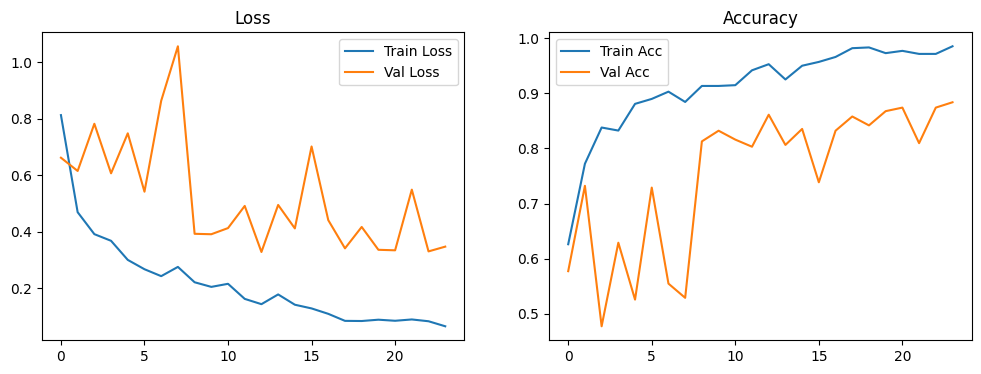

In [7]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=24,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

#**Loads the best saved model, predicts on the test set, calculates accuracy and F1 score, and plots the ROC curve with AUC.**

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step
Test Accuracy: 0.90
Test F1 Score: 0.91


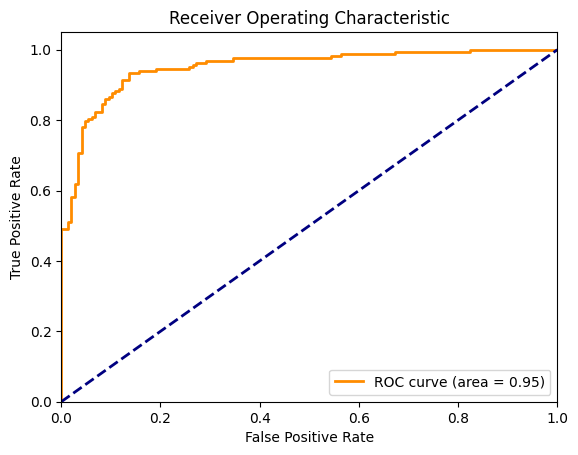

In [8]:
best_model = load_model('best_model.h5')

# Predict on test set
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.2f}")
print(f"Test F1 Score: {f1:.2f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#**Selects a random test image, predicts its label using the model, and displays the image with true and predicted labels along with confidence score.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


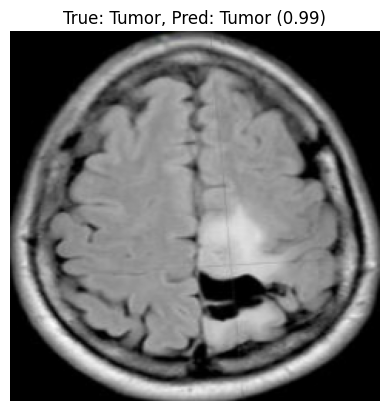

In [9]:
idx = np.random.randint(0, len(X_test))
sample_img = X_test[idx]
true_label = 'Tumor' if y_test[idx] == 1 else 'No Tumor'

# Predict
pred_prob = best_model.predict(np.expand_dims(sample_img, axis=0))[0][0]
pred_label = 'Tumor' if pred_prob > 0.5 else 'No Tumor'
confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob

# Display
plt.imshow(cv2.cvtColor(sample_img.astype('float32'), cv2.COLOR_BGR2RGB))
plt.title(f"True: {true_label}, Pred: {pred_label} ({confidence:.2f})")
plt.axis('off')
plt.show()

#**Defines functions to crop brain contours and preprocess images, loads the trained model, uploads a single MRI image, predicts its label, and displays the image with the prediction and confidence score.**

Please upload an MRI image (jpg or png format)


Saving 014.jpg to 014.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
Prediction: Tumor (Confidence: 0.99)


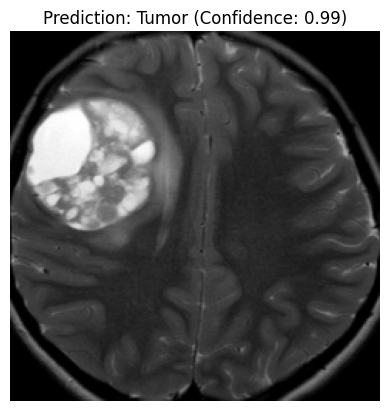

In [12]:
def crop_brain_contour(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]  # Handle OpenCV version differences
        if len(cnts) == 0:
            return image
        c = max(cnts, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
        return new_image
    except:
        return image  # Return original if cropping fails

def preprocess_image(img_path, img_size=(240, 240)):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Failed to load image. Please check the file path.")
    img = crop_brain_contour(img)
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Cell 3: Load the trained model
model = load_model('best_model.h5')

# Cell 4: Upload and predict on a single image
print("Please upload an MRI image (jpg or png format)")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Preprocess the image
img = preprocess_image(img_path)
img_input = np.expand_dims(img, axis=0)  # Add batch dimension

# Make prediction
pred_prob = model.predict(img_input)[0][0]
pred_label = 'Tumor' if pred_prob > 0.5 else 'No Tumor'
confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob

# Display result and image
print(f"Prediction: {pred_label} (Confidence: {confidence:.2f})")
plt.imshow(cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {pred_label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()

**Powered By Miracle⚡**